In [1]:
import disentangler as dt
from disentangler.dependencies import *
from scvi.model import SCANVI, SCVI

INFO:pytorch_lightning.utilities.seed:Global seed set to 0


In [2]:
rna_data = dt.bonemarrow.utils.load_GEX_data()

In [3]:
sc.tl.pca(rna_data, use_highly_variable=True, n_comps = 50)

### Load models

In [4]:
mira_model = mira.topics.load_model(dt.bonemarrow.config.MIRA_RNA + '2')
mira_no_correction = mira.topics.load_model(dt.bonemarrow.config.MIRA_RNA_NO_CORRECTION)
scvi_model = SCVI.load(dt.bonemarrow.config.SCVI, adata=rna_data)
scanvi_model = SCANVI.load(dt.bonemarrow.config.SCANVI, adata = rna_data)

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


INFO     File data/bonemarrow/models/scvi.pth/model.pt already downloaded                    


INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


INFO     File data/bonemarrow/models/scanvi.pth/model.pt already downloaded                  


### Calculate latent spaces

In [5]:
mira_no_correction.predict(rna_data, add_key='X_no_correction_topics', add_cols=False)

Predicting latent vars:   0%|          | 0/247 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_no_correction_topics
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


In [6]:
mira_no_correction.get_umap_features(rna_data, box_cox=0.1, 
                                     key = 'X_no_correction_topics',
                                    add_key = 'MIRA_no_correction_umap_features')

mira_no_correction.get_umap_features(rna_data, box_cox=0.5, 
                                     key = 'X_no_correction_topics',
                                    add_key = 'X_no_correction_umap_features')

INFO:mira.adata_interface.topic_model:Fetching key X_no_correction_topics from obsm
INFO:mira.adata_interface.core:Added key to obsm: MIRA_no_correction_umap_features
INFO:mira.adata_interface.topic_model:Fetching key X_no_correction_topics from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_no_correction_umap_features


In [7]:
mira_model.predict(rna_data)
mira_model.get_umap_features(rna_data, box_cox=0.1)
rna_data.obsm['MIRA_umap_features'] = rna_data.obsm['X_umap_features'].copy()
mira_model.get_umap_features(rna_data, box_cox = 0.5)

Predicting latent vars:   0%|          | 0/247 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


In [8]:
rna_data.obsm['scvi_features'] = scvi_model.get_latent_representation(rna_data)
rna_data.obsm['scanvi_features'] = scanvi_model.get_latent_representation(rna_data)

In [9]:
import harmonypy as hm
ho = hm.run_harmony(rna_data.obsm['X_pca'][:,:50], rna_data.obs, ['Site','DonorNumber'])

rna_data.obsm['X_harmony'] = ho.Z_corr.T

2022-08-27 15:18:30,975 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2022-08-27 15:19:01,921 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2022-08-27 15:19:33,216 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2022-08-27 15:20:04,424 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2022-08-27 15:20:21,292 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2022-08-27 15:20:32,590 - harmonypy - INFO - Converged after 5 iterations
INFO:harmonypy:Converged after 5 iterations


# Calculate silhouettes

In [10]:
joint_celltype_batchcols = rna_data.obs['cell_type'].astype(str) \
    + ":" + rna_data.obs['Site'].astype(str)

In [11]:
latent_spaces = ['X_umap_features', 'X_no_correction_umap_features','scvi_features', 'scanvi_features','X_harmony','X_pca']
umap_spaces = ['MIRA_umap_features', 'MIRA_no_correction_umap_features'] + latent_spaces[2:]

In [12]:
from sklearn.metrics import silhouette_samples

In [13]:
for space in latent_spaces:
    
    batch = \
        silhouette_samples(
            rna_data.obsm[space],
            joint_celltype_batchcols,
        )
    
    
    cell = \
        silhouette_samples(
            rna_data.obsm[space],
            rna_data.obs_vector('cell_type'),
        )
    
    rna_data.obs[space + '_batch-silhouette'] = batch
    rna_data.obs[space + '_silhouette'] = cell
    
    print(space + ':', np.mean(cell), np.mean(batch))

X_umap_features: 0.19724246809051119 -0.0763147198582058
X_no_correction_umap_features: 0.16083198557291203 0.03620747302004699
scvi_features: 0.071464434 -0.019566974
scanvi_features: 0.17198212 -0.030353813
X_harmony: 0.09296254 -0.045017723
X_pca: 0.10064055 0.021937232


In [14]:
for space in umap_spaces:
    sc.pp.neighbors(rna_data, use_rep = space, metric = 'manhattan' if space == 'MIRA_umap_features' else 'euclidean')
    sc.tl.umap(rna_data, min_dist = 0.1, negative_sample_rate = 3)
    rna_data.obsm[space + '_UMAP'] = rna_data.obsm['X_umap'].copy()

In [15]:
!mkdir -p figure1
!mkdir -p figure1/umaps

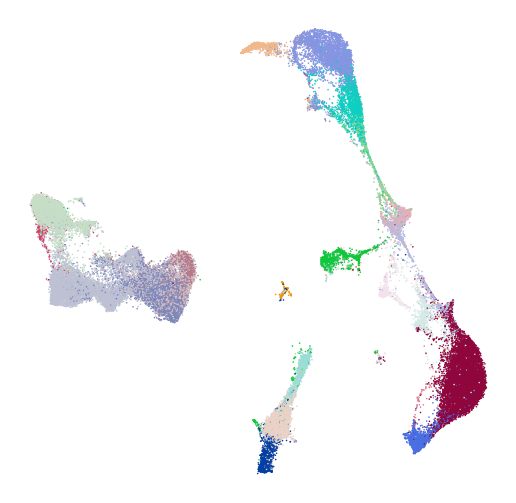

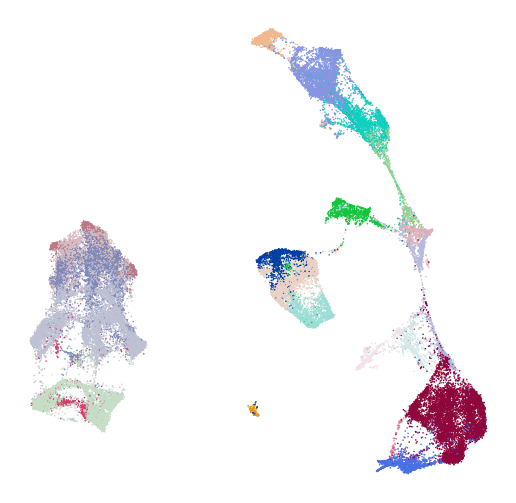

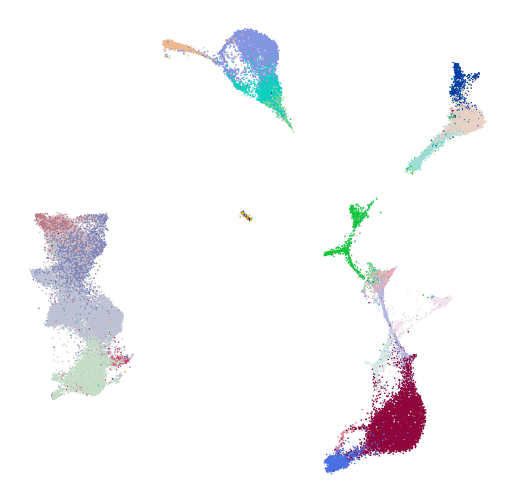

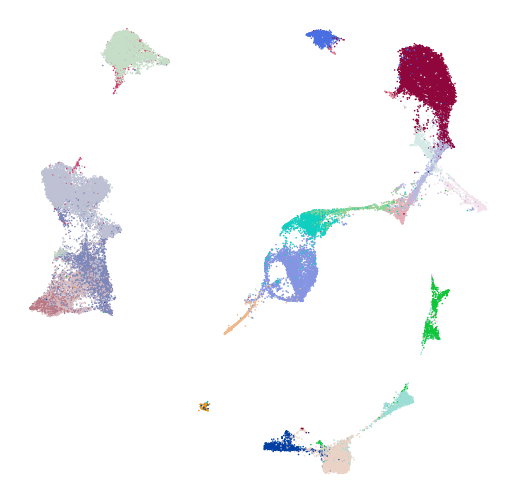

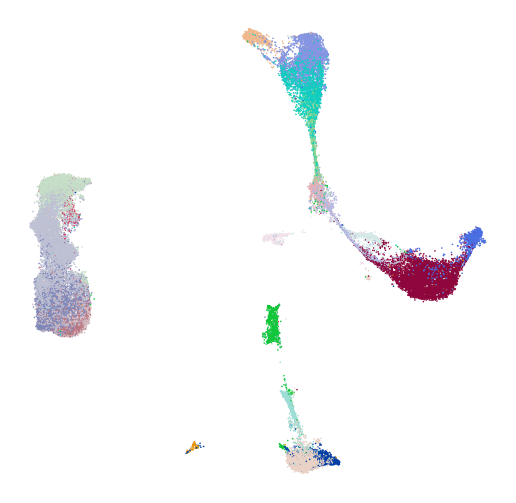

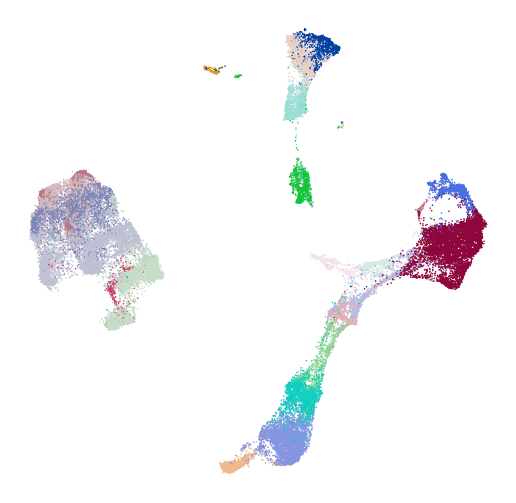

In [16]:
for basis in umap_spaces:
    
    fig, ax = plt.subplots(1,1,figsize=(9,9))
    sc.pl.embedding(rna_data, color = 'cell_type', ax = ax, frameon=False, s = 10, palette= dt.bonemarrow.colors.CELL_PALETTE,
              legend_loc='none', title = '', show = False, alpha = 1., basis = basis + '_UMAP')
    plt.savefig('figure1/umaps/{}_celltypes.png'.format(basis), dpi = 300, bbox_inches = 'tight')

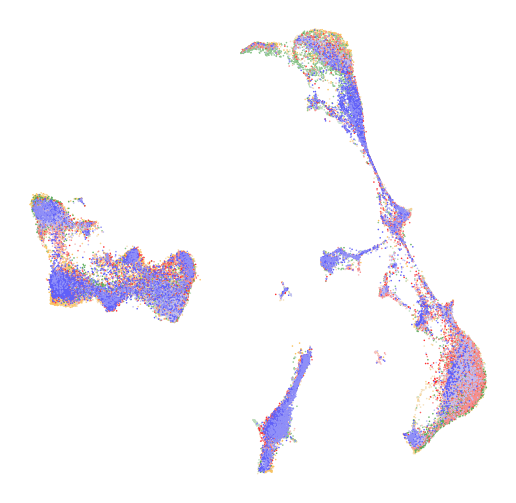

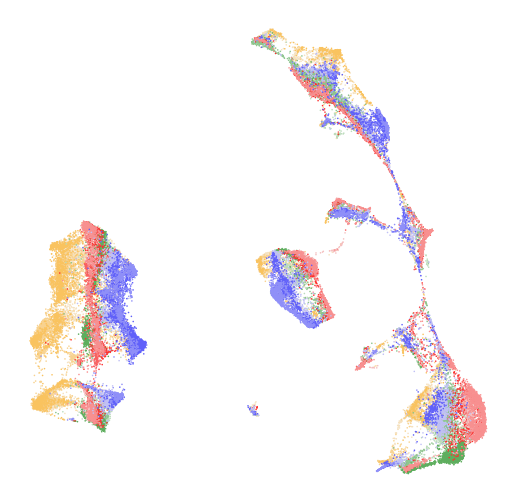

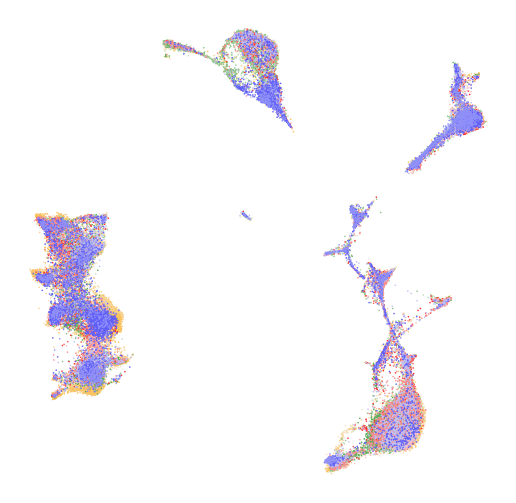

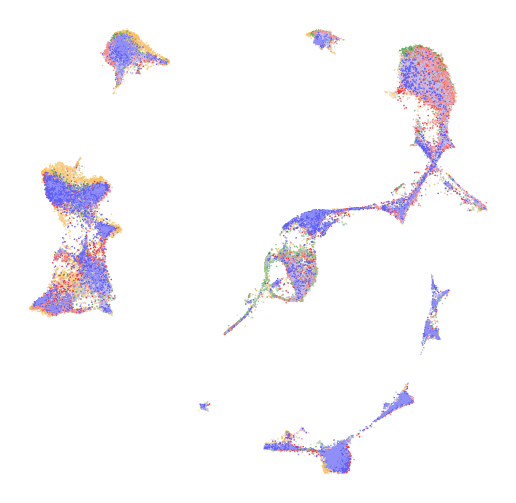

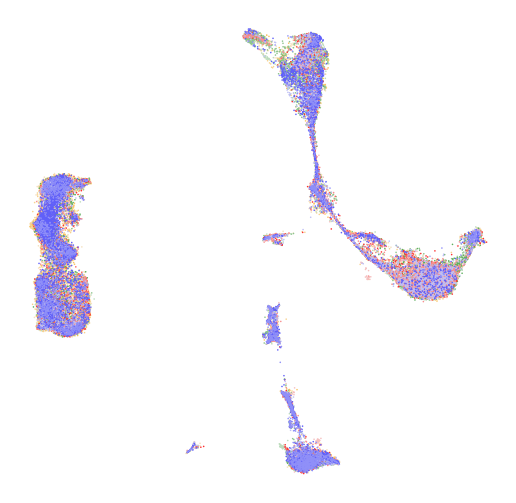

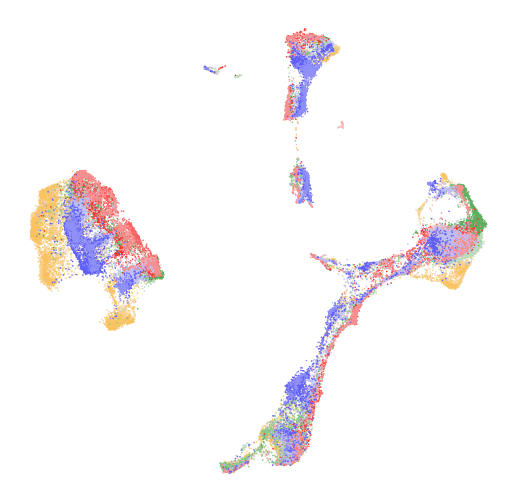

In [17]:
for basis in umap_spaces:
    
    fig, ax = plt.subplots(1,1,figsize=(9,9))
    sc.pl.embedding(rna_data, color = 'batch', ax = ax, frameon=False, s = 10, palette= dt.bonemarrow.colors.BATCH_PALETTE,
              legend_loc='none', title = '', show = False, alpha = 1., basis = basis + '_UMAP')
    plt.savefig('figure1/umaps/{}_batch.png'.format(basis), dpi = 300, bbox_inches = 'tight')

In [18]:
silhouette_cols = ['X_umap_features_batch-silhouette', 'X_umap_features_silhouette',
        'X_no_correction_umap_features_batch-silhouette', 'X_no_correction_umap_features_silhouette',
       'scvi_features_batch-silhouette', 'scvi_features_silhouette',
       'scanvi_features_batch-silhouette', 'scanvi_features_silhouette',
       'X_harmony_batch-silhouette', 'X_harmony_silhouette',
       'X_pca_batch-silhouette', 'X_pca_silhouette']

silhouettes = rna_data.obs[silhouette_cols].mean(0).to_frame().reset_index()\
    .rename(columns = {'index' : 'space_type', 0 : 'score'})

silhouettes['space'] = list(map(lambda x : '_'.join(x[:-1]), silhouettes['space_type'].str.split('_')))
silhouettes['batch_features'] = silhouettes['space_type'].str.contains('batch')

scores = silhouettes.pivot('space', columns='batch_features', values='score').reset_index()

scores['is_supervised'] = scores.space == 'scanvi_features'

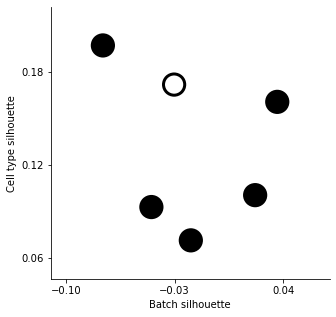

In [19]:
ax = fig, ax = plt.subplots(1,1,figsize=(5,5))

sns.scatterplot(
    data = scores,
    y = False,
    x = True,
    s = 450,
    palette= {True : 'white', False : 'black'},
    edgecolor = 'black',
    linewidth = 3,
    hue = 'is_supervised',
    ax  = ax,
    legend=False
)

ax.set_xmargin(0.3)
ax.set_ymargin(0.3)
ax.axis('equal')
ax.set(ylabel = 'Cell type silhouette', xlabel = 'Batch silhouette',
      xticks = [-0.1, -0.03, 0.04], yticks = [0.06, 0.12, 0.18])
sns.despine()

plt.savefig('figure1/silhouette_scores.svg')

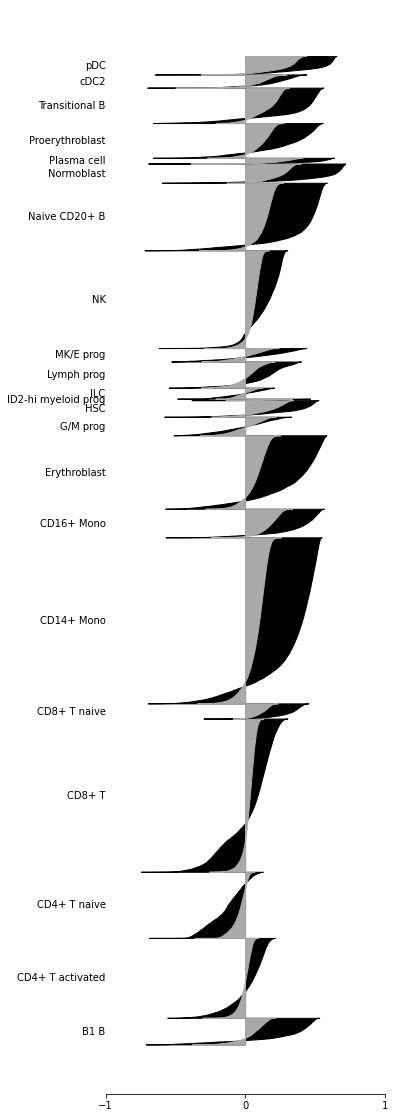

In [20]:
fig, ax = plt.subplots(1,1,figsize=(5,20))

i = 0
for cluster, color in dt.bonemarrow.colors.CELL_PALETTE.items():
    
    scores = rna_data[rna_data.obs.cell_type == cluster].obs['X_umap_features_silhouette']
    competitor_scores = rna_data[rna_data.obs.cell_type == cluster].obs['scvi_features_silhouette']
    
    plt.fill_betweenx(
        np.arange(i, i + len(scores)),
        np.sort(scores),
        color = 'black',
        alpha = 1.,
    )
    
    
    plt.fill_betweenx(
        np.arange(i, i + len(scores)),
        np.sort(competitor_scores),
        color = 'darkgrey',
        alpha = 1.,
    )
    
    
    i+=len(scores)
    
    ax.text(-1, i - len(scores)//2, cluster, 
            ha = 'right', va = 'center')
    
sns.despine()
ax.set(xlim = (-1,1), yticks = [], xticks = [-1, 0, 1])
ax.spines['left'].set_visible(False)
plt.savefig('figure1/silhouette_cascade_plot.svg', bbox_inches = 'tight',
               dpi = 300)

## Topic analysis

In [21]:
from mira.plots.base import map_plot, plot_umap, map_colors

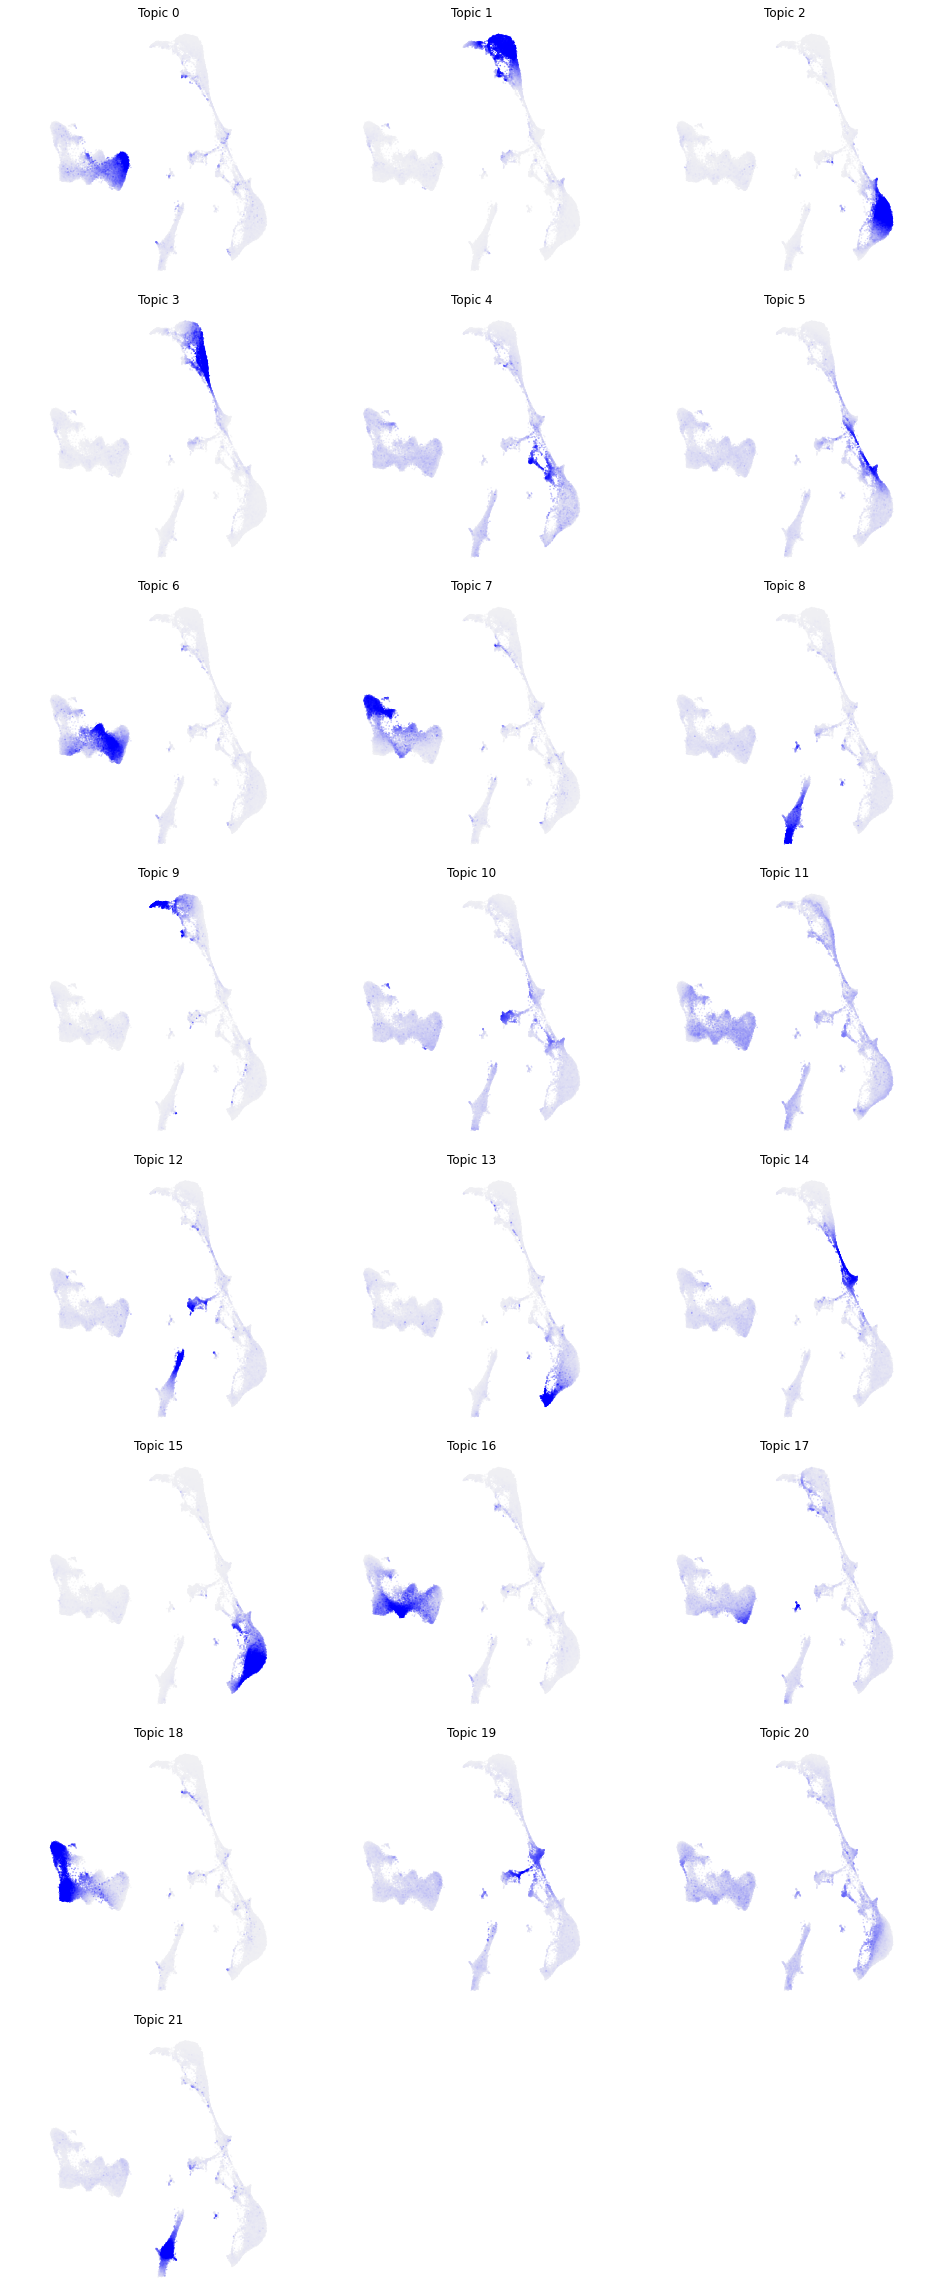

In [22]:
def topic_umap(ax, topic):
    
    ax = plot_umap(
        rna_data.obsm['MIRA_umap_features_UMAP'],
        rna_data.obs_vector(topic),
        palette=sns.color_palette('light:blue', as_cmap=True),
        figsize=(5,5),
        size = 0.1,
        add_legend=False,
        vmin=-0.0,
        vmax = 0.5,
        ax = ax,
        title = 'Topic ' + topic.split('_')[-1]
    )
    ax.set_xmargin(0.2)
    ax.set_xmargin(0.2)

map_plot(topic_umap, [[x] for x in mira_model.topic_cols], plots_per_row=3, height=4, aspect=1.1)
plt.savefig('figure1/topics.png', bbox_inches = 'tight', dpi = 300)